### Reminder!

After pulling down the tutorial notebook, immediately make a copy. Then do not modify the original. Do your work in the copy. This will prevent the possibility of git conflicts should the version-controlled file change at any point in the future. (The same exhortation applies to homeworks.)

# Week 5 Tutorial

## Hierarchical Modeling of the Cepheid Period-Luminosity Relation

Cepheids are stars whose brightness oscillates with a stable period, the logarithm of which appears to be strongly correlated with their mean absolute magnitude. If this period-luminosity relation is universal, this would give us a way to measure the distance to galaxies containing Cepheid stars.

In this problem we'll use the data from Riess et al. (2011; R11) to infer, hierarchically, the hyperparameters that govern the cepheid period-luminosity relation in a sample of nearby galaxies, and answer the following question: 

* How universal is the cepheid period-luminosity relation, once the distances to the galaxies is taken into account?

A universal relation would lead to each galaxy showing the same slope and intercept in their cepheids' P-L relation. However, it could be that cepheid hosts are only *approximately* universal with regard to their cepheids, with the parameters of the period-luminosity relation following some broad, peaked distribution. By modeling the R11 dataset under this assumption of approximate universality we can infer the width of this distribution, and see how universal the P-L relation is.

### Preliminaries

Imports:

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import corner
%matplotlib inline

class SolutionMissingError(Exception):
    def __init__(self):
        Exception.__init__(self,"You need to complete the solution for this code to work!")


def REPLACE_WITH_YOUR_SOLUTION():
    data = []
    plt.plot(data)
    plt.show()
#    raise SolutionMissingError

Read in the data (you should have a look at the files themselves to see what they contain) and plot it.

In [2]:
import os
try:
    exec(open('Solution/where_the_data_at.py').read())
except IOError:
    data_path = os.path.abspath('../../data') + '/' # relative or absolute path to the folder where the R11 data live
                                             # e.g., "../data/"

cepheids = pd.DataFrame(np.loadtxt(data_path + 'R11ceph.dat'), columns=['id','gal','m','merr','P','logO_H','bias'])
galaxies = pd.DataFrame(np.loadtxt(data_path + 'R11redsh.dat'), columns=['gal','z'])

In [3]:
cepheids.head()

,id,gal,m,merr,P,logO_H,bias
0,27185.0,4536.0,24.5123,0.31,13.00,-3.46,0.13
1,42353.0,4536.0,25.9907,0.74,13.07,-3.03,0.37
2,50718.0,4536.0,24.1492,0.42,13.73,-3.36,0.28
3,72331.0,4536.0,24.4751,0.44,13.91,-3.19,0.22
4,65694.0,4536.0,24.8582,0.38,14.38,-3.10,0.39


In [4]:
galaxies.head()

,gal,z
0,1309.0,0.007125
1,3021.0,0.005140
2,3370.0,0.004266
3,3982.0,0.003699
4,4038.0,0.005477


Tack on a column to `cepheids` holding the log-period:

In [5]:
try:
    exec(open('Solution/calc_logP.py').read())
except IOError:
    cepheids['logP'] = np.log(cepheids['P'])

In [6]:
cepheids.head()

,id,gal,m,merr,P,logO_H,bias,logP
0,27185.0,4536.0,24.5123,0.31,13.00,-3.46,0.13,2.564949
1,42353.0,4536.0,25.9907,0.74,13.07,-3.03,0.37,2.570320
2,50718.0,4536.0,24.1492,0.42,13.73,-3.36,0.28,2.619583
3,72331.0,4536.0,24.4751,0.44,13.91,-3.19,0.22,2.632608
4,65694.0,4536.0,24.8582,0.38,14.38,-3.10,0.39,2.665838


It'll be convenient to have a list of the NGC identifiers. For sanity, verify that these are identical between the two data files above.

In [7]:
ngcs = np.sort(galaxies['gal'])
np.all(ngcs == np.unique(cepheids['gal']))

True

Plot the P-L relation without adjusting magnitudes for the distance to each galaxy

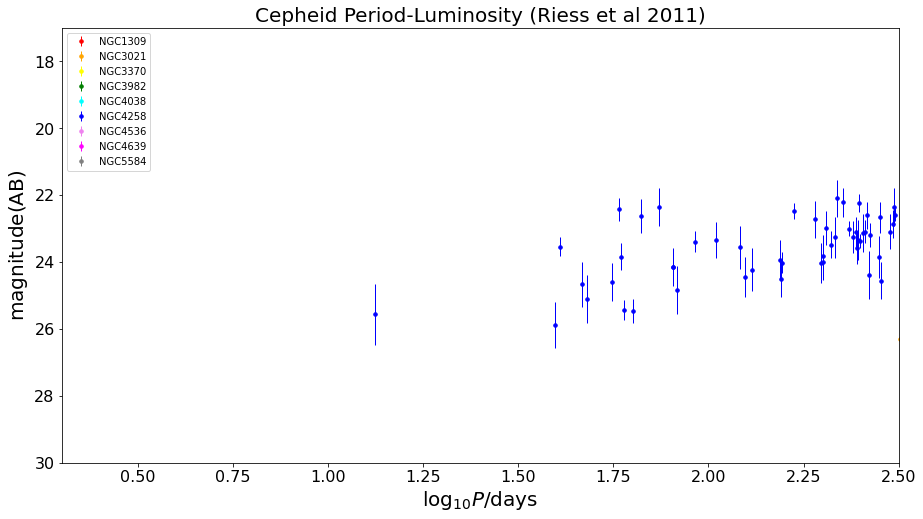

In [8]:
gal_colors = ['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'violet', 'magenta', 'gray']
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.xlim([0.3, 2.5])
plt.ylim([30.0, 17.0]) # magnitudes go backwards!
for ngc,color in zip(ngcs, gal_colors):
    this = cepheids[cepheids.gal == ngc]
    plt.errorbar(this.logP, this.m, yerr=this.merr, fmt='.', ms=7, lw=1, color=color, label='NGC'+str(int(ngc)))
plt.xlabel('$\\log_{10} P / {\\rm days}$', fontsize=20)
plt.ylabel('${\\rm magnitude (AB)}$', fontsize=20)
plt.title('Cepheid Period-Luminosity (Riess et al 2011)', fontsize=20)
plt.legend(loc='upper left');

Apparent magnitude $m$ is related to absolute magnitude $M$ via the luminosity distance $D_L$ in Mpc via

$m = M + 5 \log_{10}{D_L} + 25$

The host galaxies in the R11 sample are all very nearby (check the maximum redshift read in above), so let's assume that distance is proportional to redshift $z$ via Hubble's law:

$D_L = \frac{cz}{H_0}$ where $c = 3\times10^5 {\rm ~km~s}^{-1}$ and $H_0 = 70 {\rm ~km~s}^{-1} {\rm Mpc}^{-1}$


If we also assume the redshifts to each galaxy are known perfectly, we can convert apparent to absolute magnitude for every Cepheid without fuss.

In [9]:
def calc_DL(galaxies):
    return galaxies['z'] * 3 * (10**5) / 70

def calc_M(galaxies, cepheids, ngc):
    j = (cepheids.gal == ngc)
    DL = galaxies.loc[(galaxies.gal == ngc), 'DL'].tolist()[0]
    return cepheids.loc[j, 'm'] - 5 * np.log10(DL) - 25

try:
    exec(open('Solution/calc_M.py').read())
except IOError:
    c = 3.0e5 # km/s
    H0 = 70.0 # km/s/Mpc
    galaxies['DL'] = calc_DL(galaxies)
    cepheids['M'] = np.nan
    for ngc in ngcs:
        j = (cepheids.gal == ngc)
        cepheids.loc[j,'M'] = calc_M(galaxies, cepheids, ngc)


In [10]:
galaxies.head()

,gal,z,DL
0,1309.0,0.007125,30.535714
1,3021.0,0.005140,22.028571
2,3370.0,0.004266,18.282857
3,3982.0,0.003699,15.852857
4,4038.0,0.005477,23.472857


In [11]:
cepheids.head()

,id,gal,m,merr,P,logO_H,bias,logP,M
0,27185.0,4536.0,24.5123,0.31,13.00,-3.46,0.13,2.564949,-7.549763
1,42353.0,4536.0,25.9907,0.74,13.07,-3.03,0.37,2.570320,-6.071363
2,50718.0,4536.0,24.1492,0.42,13.73,-3.36,0.28,2.619583,-7.912863
3,72331.0,4536.0,24.4751,0.44,13.91,-3.19,0.22,2.632608,-7.586963
4,65694.0,4536.0,24.8582,0.38,14.38,-3.10,0.39,2.665838,-7.203863


Plot absolute magnitudes. Note that, since we're assuming a perfectly known, additive translation from $m$ to $M$, the `merr` column of `galaxies` describes the uncertainty either $m$ or $M$.

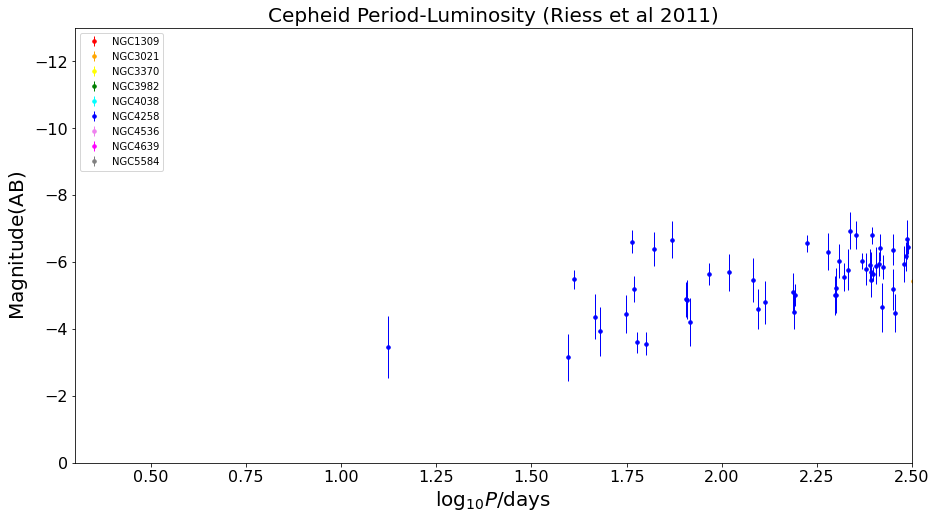

In [12]:
plt.xlim([0.3, 2.5])
plt.ylim(np.array([30.0, 17.0])-25.0-5.0) # magnitudes go backwards!
for ngc,color in zip(ngcs, gal_colors):
    this = cepheids[cepheids.gal == ngc]
    plt.errorbar(this.logP, this.M, yerr=this.merr, fmt='.', ms=7, lw=1, color=color, label='NGC'+str(int(ngc)))
plt.xlabel('$\\log_{10} P / {\\rm days}$', fontsize=20)
plt.ylabel('${\\rm Magnitude (AB)}$', fontsize=20)
plt.title('Cepheid Period-Luminosity (Riess et al 2011)', fontsize=20)
plt.legend(loc='upper left');

### Model

In addition to the assumptions above, let's incorporate the following into our model:

* In cepheids, absolute magnitude is related to the log period $\log_{10}P$ via a simple, linear relation

$M = a_i + b_i \log_{10}P$ with $i$ indexing the host galaxies.

* The period-luminosity relations in the host galaxies might be different from one another, but not _very_ different. 

We'll assume that the slope and intercept parameters are drawn from two independent Gaussian distributions of unknown width ($\sigma_b$ and $\sigma_a$) and mean ($\bar{b}$ and $\bar{a}$), such that cepheid behavior is approximately universal, but still potentially sensitive to host galaxy environment.

Let's also assume that
* there is no intrinsic scatter in the cepheid period-luminosity relation _within_ a given host galaxy.

* the measurement errors given by `merr` are Gaussian.

* periods are known precisely.

#### A complete model

Draw the PGM for the hierarchical model defined by the assumptions listed above. Make sure you include all the variables:

* The observed apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $m^{\rm obs}_{ij}$
* The "true" apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $m_{ij}$
* The true absolute magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $M_{ij}$
* The log period for the $j^{th}$ cepheid in the $i^{th}$ galaxy, $\log_{10}P_{ij}$
* The known observational uncertainty on the apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $\sigma^{\rm obs}_{ij}$

* The luminosity distance to the $i^{th}$ galaxy, $D_{L,i}$
* The slope parameter of the period-luminosity relation in the $i^{th}$ galaxy, $b_{i}$
* The intercept parameter of the period-luminosity relation in the $i^{th}$ galaxy, $a_{i}$

* The mean and standard deviation of the Gaussian distribution of period-luminosity relation slopes, the hyperparameters $\bar{b}$ and $\sigma_b$
* The mean and standard deviation of the Gaussian distribution of period-luminosity relation intercepts, the hyperparameters $\bar{a}$ and $\sigma_a$

#### A simplified model

With the above assumptions of Gaussian magnitude errors, zero period uncertainties, and no intrinsic scatter within a host galaxy, the problem can be simplified considerably. 

In this case, all the data for a given host galaxy can be *summarized* without loss of information by the results of a weighted least squares (WLS) regression of the P-L relation for the Cepheids in that galaxy. WLS gives us the posterior mean and covariance for $a_i$ and $b_i$ that we would get assuming uniform priors on $a_i$ and $b_i$.

Of course, in the end we will not want to assume uniform priors; our model describes the distribution of $a$'s and $b$'s as Gaussian. So the problem isn't fully solved yet, but it will simplify.

Don't take our word for it. Write down an expression for the likelihood in this problem (you can leave out the deterministic parts involving $m$ and $D_L$), and convince yourself that the substitution

$\prod_j p(M_{ij}|P_{ij},\sigma_{ij},a_i,b_i) \rightarrow p(\mu_i|\Sigma_i,a_i,b_i)$

makes sense. Here $\mu_i$ and $\Sigma_i$ would be the best fit and covariance of the WLS parameters, and the rhs distribution is a 2D Gaussian.

Adopting the list of $\mu_i$ and $\Sigma_i$ as summaries of the data, draw a much simpler PGM for the problem.

Now, of course, you get to compute the WLS regressions for each galaxy. This is reasonably convenient with the `statsmodels` package.

In [13]:
# Suggestions:
# We get to juggle covariance matrices now, so perhaps give up on using pandas to organize things, and resort to dicts.
# Also, subtract ~1.5 from the log(P)'s to approximately center them on zero.
# This trick reduces the covariance of the WLS parameters, which will ultimately make our sampling more efficient.
# But don't forget when interpreting the intercepts!
import statsmodels.api as sm
def get_wls_model(this):
    model = sm.WLS(this.M, this.loc[:, 'logP'])
    return model

try:
    exec(open('Solution/do_WLS.py').read())
except IOError:
    mu_a = {} # dictionaries to be indexed by galaxy name, holding an average a
    mu_b = {} # an average b,
    Sigma = {} # and a covariance matrix from WLS fit
    for ngc in ngcs:
        this = cepheids[cepheids.gal == ngc]
        model = get_wls_model(this) # check out the documentation for statsmodels.api.WLS
        wls = model.fit()
        j = (galaxies.gal == ngc)
        mu_a[ngc] = REPLACE_WITH_YOUR_SOLUTION()
        mu_b[ngc] = REPLACE_WITH_YOUR_SOLUTION()
        Sigma[ngc] = np.asmatrix( REPLACE_WITH_YOUR_SOLUTION() )

TypeError: get_wls_model() missing 1 required positional argument: 'this'

Just to prove this did something reasonable, lets plot the individual WLS fits over the data. And then never look at the full Cepheid data ever again.

NB, the code below assumes that you *did* subtract 1.5 from the log-periods before doing the WLS.

In [ ]:
plt.xlim([0.3, 2.5])
plt.ylim(np.array([30.0, 17.0])-25.0-5.0) # magnitudes go backwards!
for ngc,color in zip(ngcs, gal_colors):
    this = cepheids[cepheids.gal == ngc]
    plt.errorbar(this.logP, this.M, yerr=this.merr, fmt='.', ms=7, lw=1, color=color, label='NGC'+str(int(ngc)))
    plt.plot(np.sort(this.logP), mu_a[ngc]+mu_b[ngc]*np.sort(this.logP-1.5), color=color, label='')
plt.xlabel('$\\log_{10} P / {\\rm days}$', fontsize=20)
plt.ylabel('${\\rm Magnitude (AB)}$', fontsize=20)
plt.title('Cepheid Period-Luminosity (Riess et al 2011)', fontsize=20)
plt.legend(loc='upper left');

And let's look at the individual $\mu_a$'s and $\mu_b$'s (ignoring the error covariance for plotting).

In [ ]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.errorbar([mu_a[ngc] for ngc in ngcs], [mu_b[ngc] for ngc in ngcs], xerr=np.sqrt([Sigma[ngc][0,0] for ngc in ngcs]),
            yerr=np.sqrt([Sigma[ngc][1,1] for ngc in ngcs]), fmt='.')
plt.xlabel('$\mu_a$', fontsize=20)
plt.ylabel('$\mu_b$', fontsize=20);

This problem will be continued in this week's homework assignment.